In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from scipy import sparse
from scipy.sparse import linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator

# class for data (geometry, material property, mesh)

In [1]:
class mydata:
    
    def __init__(self, cond_layout, qext_layout, nref, L, pb_dim=2):
        # cond_layout: 2D layout of the conductivity (material zones)
        # qext_layout: 2D layout of the heat source (material zones)
        #     Note the two layouts must be of compatible shape
        # nref: a list or array of length 2 containing the number of mesh refinement in x and y
        #     Note that mesh refinement is uniform in this code
        # L: a list or array of legnth 2 containing the Lx and Ly dimensions
        
        # sanity checks
        if pb_dim != 2:
            raise ValueError('Only pb_dim=2 for now')
        if cond_layout.ndim !=2:
            raise ValueError('cond_layout: only dim=2 for now')
        if qext_layout.ndim !=2:
            raise ValueError('qext_layout: only dim=2 for now')
        if cond_layout.shape != qext_layout.shape:
            raise ValueError('cond_layout and qext_layout of different shapes')
        if len(nref) !=2:
            raise ValueError('nref: only len=2 for now')
        if len(L) !=2:
            raise ValueError('L: only len=2 for now')
        
        # refine the mesh and update material and source layouts
        repeats = np.asarray(nref, dtype=int)
        self.cond = self.repeat_array(cond_layout,repeats)
        self.qext = self.repeat_array(qext_layout,repeats)

        # mesh data
        # cells
        self.ncells_x, self.ncells_y = self.cond.shape
        # vertices
        self.npts_x = self.ncells_x + 1
        self.npts_y = self.ncells_y + 1
        self.n_verts = self.npts_x * self.npts_y 
        # coordinates
        self.x = np.linspace(0,L[0],self.npts_x)
        self.y = np.linspace(0,L[1],self.npts_y)
        
        self.dx = L[0] / self.ncells_x
        self.dy = L[1] / self.ncells_y
        
        # nodal connectivity for cFEM
        self.connectivity()

            
    def repeat_array(self, arr,repeats):
        for dim,n in enumerate(repeats):
            arr = np.repeat(arr,n,axis=dim)
        return arr        
    
    
    def connectivity(self):
        self.n_cells = self.ncells_x * self.ncells_y 
        self.gn = np.zeros((self.n_cells,4),dtype=int)

        # compute node ID from (i,j) cell identifiers
        node = lambda i,j: i+j*self.npts_x

        iel = 0
        for j in range(self.ncells_y):
            for i in range(self.ncells_x):
                # counter-clockwise
                self.gn[iel,0] = node(i  ,j  )
                self.gn[iel,1] = node(i+1,j  )
                self.gn[iel,2] = node(i+1,j+1)
                self.gn[iel,3] = node(i  ,j+1)

                iel += 1    

# class for FEM solver

In [25]:
class FEM_solver:
    def __init__(self, data):
        
        # store the data received
        self.data = data
        
        # duplicates, shortcuts
        self.ncells_x = data.ncells_x
        self.ncells_y = data.ncells_y

        self.npts_x = data.npts_x
        self.npts_y = data.npts_y
        
        self.n_nodes = data.n_verts
        self.n_cells = data.n_cells
        
        self.dx = data.dx
        self.dy = data.dy

        # compute the cFEM basis functions
        self.basis()
        # compute the elemental matrices
        self.compute_elemental_matrices()

        
    def elem2ij(self,iel,verbose=False):
        # from element ID (iel) get the (i,j) cell integers
        # iel = i + j*nx
        j = int(iel/self.ncells_x)
        i = iel-j*self.ncells_x
        if verbose:
            print("i=",i,", j=",j)
        return i,j
    
    
    def node2ij(self,ivert,verbose=False):
        # from node ID (ivert) get the (i,j) node integers
        # ivert = i +j*npts_x
        j = int(ivert/self.npts_x)
        i = ivert-j*self.npts_x
        if verbose:
            print("i=",i,", j=",j)
        return i,j
    
    
    def basis(self):
        # list of basis functions in [-1,1]^dim in counter-clockwise ordering
        self.b = []
        self.b.append(lambda u,v: (1-u)*(1-v)/4 )
        self.b.append(lambda u,v: (1+u)*(1-v)/4 )
        self.b.append(lambda u,v: (1+u)*(1+v)/4 )
        self.b.append(lambda u,v: (1-u)*(1+v)/4 )
        # their derivatives with respect to u
        self.dbdx = []
        self.dbdx.append(lambda u,v: -(1-v)/4 )
        self.dbdx.append(lambda u,v:  (1-v)/4 )
        self.dbdx.append(lambda u,v:  (1+v)/4 )
        self.dbdx.append(lambda u,v: -(1+v)/4 )
        # their derivatives with respect to v
        self.dbdy = []
        self.dbdy.append(lambda u,v: -(1-u)/4 )
        self.dbdy.append(lambda u,v: -(1+u)/4 )
        self.dbdy.append(lambda u,v:  (1+u)/4 )
        self.dbdy.append(lambda u,v:  (1-u)/4 )
        
        
    def compute_elemental_matrices(self,verbose=False):
        # select spatial quadrature
        degree = 3
        [x_,w_] = np.polynomial.legendre.leggauss(degree)

        # matrices
        local_dofs = len(self.b)
        self.Q   = np.zeros(local_dofs)
        self.M   = np.zeros((local_dofs,local_dofs))
        self.Kxx = np.zeros((local_dofs,local_dofs))
        self.Kyy = np.zeros((local_dofs,local_dofs))
        #     Kxy = np.zeros((4,4))
        #     Kyx = np.zeros((4,4)) # not needed, symmetric of Kxy

        for i,fi in enumerate(self.b):
            for (uq,wuq) in zip(x_,w_):
                for (vq,wvq) in zip(x_,w_):
                    self.Q[i]   += wuq*wvq*fi(uq,vq)

        for i,(fi,fxi,fyi) in enumerate(zip(self.b,self.dbdx,self.dbdy)):
            for j,(fj,fxj,fyj) in enumerate(zip(self.b,self.dbdx,self.dbdy)):
                for (uq,wuq) in zip(x_,w_):
                    for (vq,wvq) in zip(x_,w_):
                        self.M[i,j]   += wuq*wvq*fi (uq,vq)*fj (uq,vq)
                        self.Kxx[i,j] += wuq*wvq*fxi(uq,vq)*fxj(uq,vq)
                        self.Kyy[i,j] += wuq*wvq*fyi(uq,vq)*fyj(uq,vq)

        if verbose:
            print(self.Q)
            print(self.M)
            print(self.Kxx)
            print(self.Kyy)
            

    def assemble_system(self, bc):
        # assemble the cFEM system
        
        # sanity check
        if len(bc) !=4:
            raise ValueError('bc dictionary must have 4 keys')
                
        # stiffness matrix
        K = sparse.lil_matrix((self.n_nodes, self.n_nodes))
        # rhs
        rhs = np.zeros(self.n_nodes)

        # loop over elements
        for iel in range(self.n_cells):
            icell,jcell = self.elem2ij(iel)
            mat_prop = self.data.cond[icell,jcell]
            src_prop = self.data.qext[icell,jcell]
            for i,ind_i in enumerate(self.data.gn[iel,:]):
                rhs[ind_i] += src_prop * self.dx*self.dy/4. * self.Q[i]
                for j,ind_j in enumerate(self.data.gn[iel,:]):
                    K[ind_i,ind_j] += mat_prop*(  self.dy/self.dx*self.Kxx[i,j] \
                                                + self.dx/self.dy*self.Kyy[i,j] )

        # apply bc
        node = lambda i,j: i+j*self.npts_x
        
        dir_nodes = []
        T_dir = []
        if bc['ymin']['type'] != 'refl':
            for i in range(self.npts_x):
                dir_nodes.append( node(i,0) )
                T_dir.append(bc['ymin']['value'])
        if bc['ymax']['type'] != 'refl':
            for i in range(self.npts_x):
                dir_nodes.append( node(i,self.npts_y-1) )
                T_dir.append(bc['ymax']['value'])
        if bc['xmin']['type'] != 'refl':
            for j in range(self.npts_y):
                dir_nodes.append( node(0,j) )
                T_dir.append(bc['xmin']['value'])
        if bc['xmax']['type'] != 'refl':
            for j in range(self.npts_y):
                dir_nodes.append( node(self.npts_x-1,j) )
                T_dir.append(bc['xmax']['value'])
        dir_nodes = np.asarray(dir_nodes)
        # remove duplicate 4 corners
        # dir_nodes = np.unique(dir_nodes)

        for i,inode in enumerate(dir_nodes):
            K[inode,:]     = 0.
            K[inode,inode] = 1.
            rhs[inode]     = T_dir[i]

        return K, rhs

    
    def solve_system(self, A, b):
        solution = linalg.spsolve(A.tocsc(), b)

        return solution   

# Example 1

In [26]:
# data
cond = 100.*np.ones((4,6))
cond[1,0] =1.
cond[2,2] =1000.
cond[0,1] =1.

qext = np.zeros_like(cond)
qext[0,0] = 100.
qext[3,0] = 50.

# create data and solver objects
d = mydata(cond, qext, [22,22], [40.,60.])
solver = FEM_solver(d)

# solve
bc = {}
bc['xmin']={'type':'dirichlet','value':10.}
bc['xmax']={'type':'dirichlet','value':10.}
bc['ymin']={'type':'dirichlet','value':10.}
bc['ymax']={'type':'dirichlet','value':10.}
A,b = solver.assemble_system(bc)
solution = solver.solve_system(A, b)

# plot in 2D
XX,YY = np.meshgrid(d.x,d.y)
TT = np.reshape(solution,(d.npts_y,d.npts_x))
# print(XX.shape)
# print(YY.shape)
# print(TT.shape)

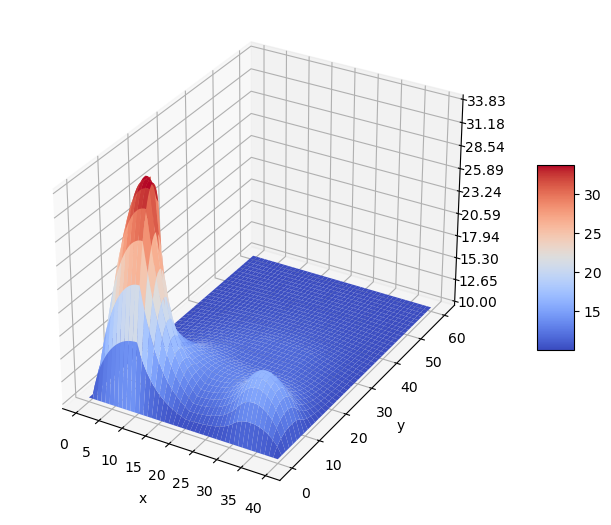

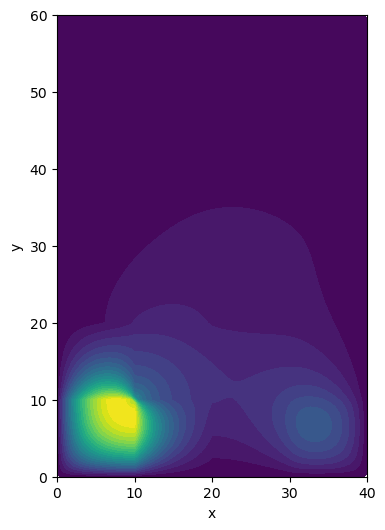

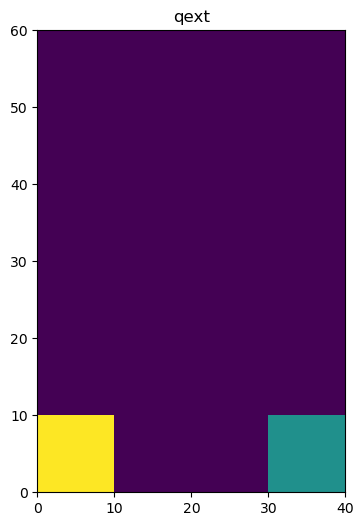

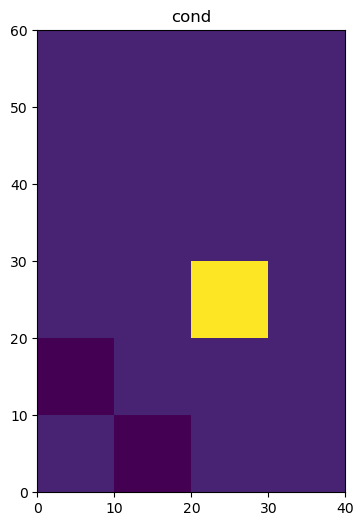

In [27]:
# figsizes
sx = 4
sy = sx * (np.max(d.y)-np.min(d.y))/ (np.max(d.x)-np.min(d.x))

# Plot the surface.
fig, ax = plt.subplots(figsize=(2*sx, 2*sy),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX.T, YY.T, TT.T, cmap=cm.coolwarm,
                       linewidth=1)#, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
# Customize the z axis.
ax.set_zlim(np.min(solution),np.max(solution))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# rotate as needed
ax.view_init(30,-60)
ax.set_box_aspect(aspect=(1, sy/sx, 1))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.show()

# easier contour plot
plt.figure(figsize=(sx, sy))
plt.contourf(XX,YY,TT,26)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# material/source layouts
plt.figure(figsize=(sx, sy))
plt.imshow(np.flip(d.qext,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
plt.title('qext')
plt.show()
plt.figure(figsize=(sx, sy))
plt.imshow(np.flip(d.cond,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
plt.title('cond')
plt.show()

# Example 2

In [48]:
# data
cond = 100.*np.ones((4,6))

qext = np.zeros_like(cond) + 4.

# create data and solver objects
L_domain = [40.,60.]
d = mydata(cond, qext, [22,22], L_domain)
solver = FEM_solver(d)

# solve
bc = {}
bc['xmin']={'type':'dirichlet','value':10.}
bc['xmax']={'type':'dirichlet','value':18.}
bc['ymin']={'type':'refl'}
bc['ymax']={'type':'refl'}
A,b = solver.assemble_system(bc)
solution = solver.solve_system(A, b)

# plot in 2D
XX,YY = np.meshgrid(d.x,d.y)
TT = np.reshape(solution,(d.npts_y,d.npts_x))

# Texact(x) = -q/2/k.x**2 + B*x + C
# Texact(0) = C = Tleft
# Texact(L) = -q/2/k*L**2 + B*L + Tleft = Tright
#   --> B = 1/L* (Tright-Tleft + q/2/k*L**2)
q,k,L,Tleft,Tright = qext[0,0],cond[0,0],L_domain[0],bc['xmin']['value'],bc['xmax']['value']
Bcoef = 1/L*(Tright-Tleft + q/2/k*L**2)
exact = lambda z: -q/2/k*z**2 + Bcoef*z + Tleft
# z_max = min(k*B/q,L)
x_max = min(k*Bcoef/q,L)
print(exact(x_max),np.max(TT))

22.5 22.50000000000502


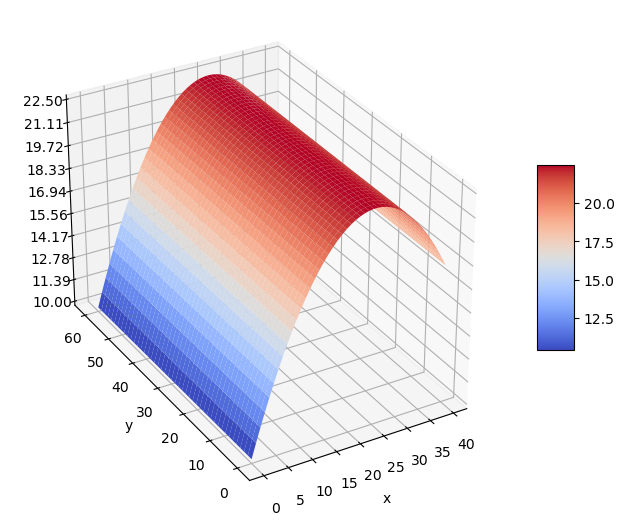

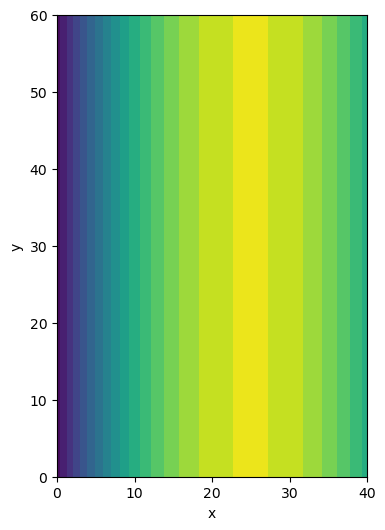

In [49]:
# figsizes
sx = 4
sy = sx * (np.max(d.y)-np.min(d.y))/ (np.max(d.x)-np.min(d.x))

# Plot the surface.
fig, ax = plt.subplots(figsize=(2*sx, 2*sy),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX.T, YY.T, TT.T, cmap=cm.coolwarm,
                       linewidth=1)#, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
# Customize the z axis.
ax.set_zlim(np.min(solution),np.max(solution))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# rotate as needed
ax.view_init(30,-120)
ax.set_box_aspect(aspect=(1, sy/sx, 1))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.show()

# easier contour plot
plt.figure(figsize=(sx, sy))
plt.contourf(XX,YY,TT,16)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# material/source layouts
# plt.figure()
# plt.imshow(np.flip(d.qext,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
# plt.show()
# plt.figure()
# plt.imshow(np.flip(d.cond,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
# plt.show()

# Example 3

In [22]:
# data
cond = 100.*np.ones((4,6))

qext = np.zeros_like(cond)

# create data and solver objects
d = mydata(cond, qext, [22,22], [40.,60.])
solver = FEM_solver(d)

# solve
bc = {}
bc['xmin']={'type':'dirichlet','value':10.}
bc['xmax']={'type':'dirichlet','value':20.}
bc['ymin']={'type':'dirichlet','value':15.}
bc['ymax']={'type':'dirichlet','value':5.}
A,b = solver.assemble_system(bc)
solution = solver.solve_system(A, b)

# plot in 2D
XX,YY = np.meshgrid(d.x,d.y)
TT = np.reshape(solution,(d.npts_y,d.npts_x))

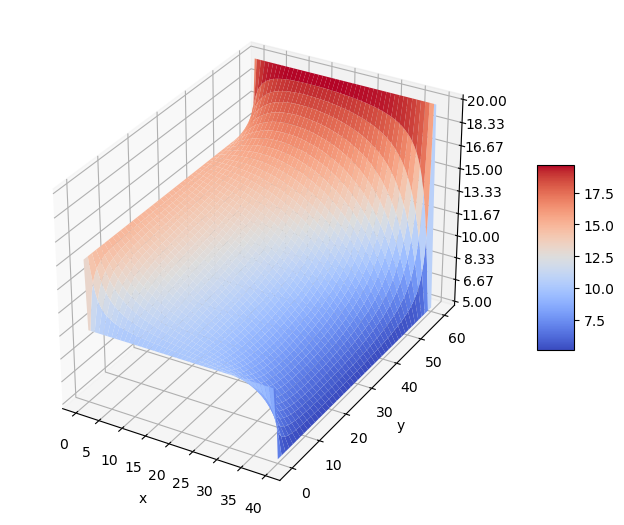

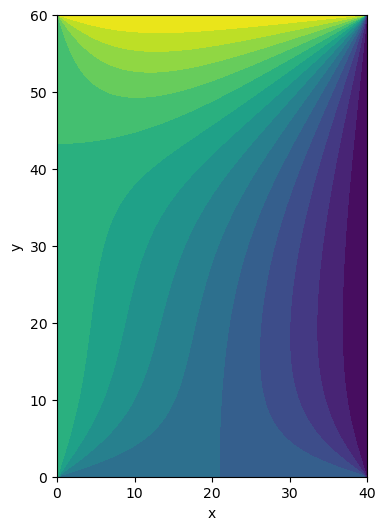

In [24]:
# figsizes
sx = 4
sy = sx * (np.max(d.y)-np.min(d.y))/ (np.max(d.x)-np.min(d.x))

# Plot the surface.
fig, ax = plt.subplots(figsize=(2*sx, 2*sy),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX.T, YY.T, TT.T, cmap=cm.coolwarm,
                       linewidth=1)#, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
# Customize the z axis.
ax.set_zlim(np.min(solution),np.max(solution))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# rotate as needed
ax.view_init(30,-60)
ax.set_box_aspect(aspect=(1, sy/sx, 1))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.show()

# easier contour plot
plt.figure(figsize=(sx, sy))
plt.contourf(XX,YY,TT,16)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# material/source layouts
# plt.figure()
# plt.imshow(np.flip(d.qext,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
# plt.show()
# plt.figure()
# plt.imshow(np.flip(d.cond,axis=1).T, interpolation='none', extent=[np.min(d.x),np.max(d.x),np.min(d.y),np.max(d.y)])
# plt.show()

# Example 4

In [52]:
# data
cond = 1.*np.ones((3,2))

qext = 1.*np.ones((3,2))

# create data and solver objects
L_domain = [12.,14.]
d = mydata(cond, qext, [20,21], L_domain)
solver = FEM_solver(d)

# solve
bc = {}
bc['xmin']={'type':'dirichlet','value':0.}
bc['xmax']={'type':'dirichlet','value':0.}
bc['ymin']={'type':'refl','value':0.}
bc['ymax']={'type':'refl','value':0.}

A,b = solver.assemble_system(bc)
solution = solver.solve_system(A, b)

# plot in 2D
XX,YY = np.meshgrid(d.x,d.y)
TT = np.reshape(solution,(d.npts_y,d.npts_x))

# Replace the minimum value with small>0
# min_val = 0.001
# TT[TT <= min_val] = 0.001
print('Max value=',np.max(TT))

q,k,L = qext[0,0],cond[0,0],L_domain[0]
exa = lambda z: q/2/k*z*(L-z)
print('exact max =',exa(L/2))

Max value= 17.999999999999986
exact max = 18.0


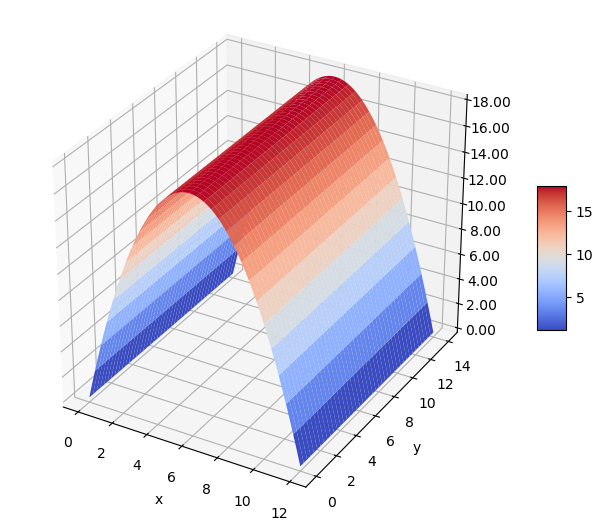

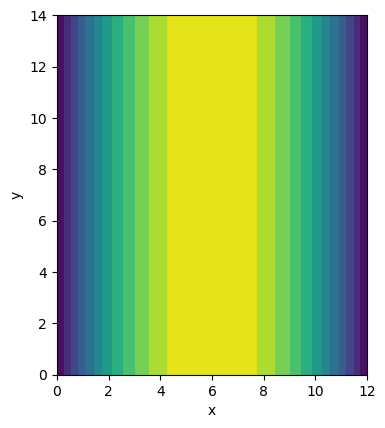

In [54]:
# figsizes
sx = 4
sy = sx * (np.max(d.y)-np.min(d.y))/ (np.max(d.x)-np.min(d.x))

# Plot the surface.
fig, ax = plt.subplots(figsize=(2*sx, 2*sy),subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX.T, YY.T, TT.T, cmap=cm.coolwarm,
                       linewidth=1)#, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
# Customize the z axis.
ax.set_zlim(np.min(solution),np.max(solution))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# rotate as needed
ax.view_init(30,-60)
ax.set_box_aspect(aspect=(1, sy/sx, 1))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.show()

# easier contour plot
plt.figure(figsize=(sx, sy))
plt.contourf(XX,YY,TT,16)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### plotting material property and source layout (but in a convoluted way ...)

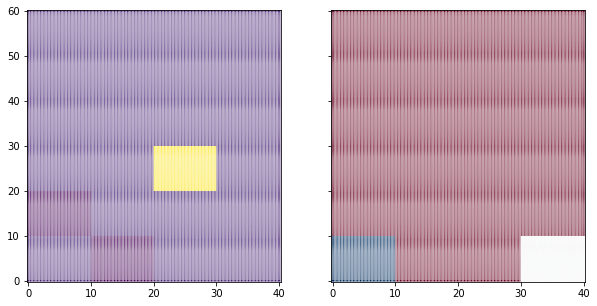

In [123]:
# generate double 2d grids for the x & y bounds
x_ = np.sort(np.append(d.x,d.x))[1:-1]
y_ = np.sort(np.append(d.y,d.y))[1:-1]
xx_,yy_ = np.meshgrid(x_,y_)

# double the layout to go with the meshgrid to make it piecewise constant per rectangle
mat_layout_viewing = np.kron(d.cond,np.ones((2,2)))
src_layout_viewing = np.kron(d.qext,np.ones((2,2)))
# plot
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
c=ax[0].pcolor(xx_, yy_, mat_layout_viewing.T, edgecolors='w', linewidths=0.25, shading='auto', cmap='viridis')
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(c, cax=cax, orientation='vertical')
# ax[0].set_title('material layout')

c2=ax[1].pcolor(xx_, yy_, src_layout_viewing.T, edgecolors='w', linewidths=0.25, shading='auto', cmap='RdBu')
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(c2, cax=cax, orientation='vertical')
# ax[1].set_title('source layout')

### old stuff

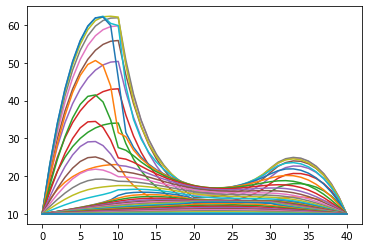

In [21]:
plt.figure()
for j in range(d.npts_y):
    plt.plot(solution[np.arange(0,d.npts_x)+j*(d.npts_x)])

Basis functions on reference square (counter-clockwise) :
\begin{align}
\hat b_0(u,v) &= (1-u)(1-v)/4\\
\hat b_1(u,v) &= (1+u)(1-v)/4\\
\hat b_2(u,v) &= (1+u)(1+v)/4\\
\hat b_3(u,v) &= (1-u)(1+v)/4
\end{align}

Mapping expression to rectangle (ABCD) (counter-clockwise)
$$
x(u,v) = x_A \hat b_0(u,v) + x_B \hat b_1(u,v) + x_C \hat b_2(u,v) + x_D \hat b_3(u,v) 
$$
and similar expression for $y(u,v)$. 

Or
$$
\begin{bmatrix}
    x(u,v)\\y(u,v)
\end{bmatrix}
=
\begin{bmatrix}
   x_A & x_B & x_C & x_D \\
   y_A & y_B & y_C & y_D 
\end{bmatrix}
\begin{bmatrix}
    \hat b_0(u,v) \\ \hat b_1(u,v) \\ \hat b_2(u,v) \\ \hat b_3(u,v) 
\end{bmatrix}
=
\begin{bmatrix}
   x_A & x_B & x_C & x_D \\
   y_A & y_B & y_C & y_D 
\end{bmatrix}
\begin{bmatrix}
    \frac{1-u-v+uv}{4} \\ \frac{1+u-v-uv}{4} \\ \frac{1+u+v+uv}{4} \\ \frac{1-u+v-uv}{4}
\end{bmatrix}
$$
Or
$$
\begin{bmatrix}
    x(u,v)\\y(u,v)
\end{bmatrix}
=
\begin{bmatrix}
    \frac{x_A+x_B+x_C+x_D}{4} \\ \frac{y_A+y_B+y_C+y_D}{4}
\end{bmatrix}
+
\begin{bmatrix}
    \frac{x_B - x_A + x_C - x_D}{4}& \frac{x_C-x_B+x_D-x_A}{4}& \frac{x_A-x_B+x_C-x_D}{4}\\
    \frac{y_B - y_A + y_C - y_D}{4}& \frac{y_C-y_B+y_D-y_A}{4}& \frac{y_A-y_B+y_C-y_D}{4}
\end{bmatrix}
\begin{bmatrix}
   u\\v\\uv
\end{bmatrix}
$$
For a regular rectangular cell, this devolves to:
$$
\begin{bmatrix}
    x(u,v)\\y(u,v)
\end{bmatrix}
=
\begin{bmatrix}
    \frac{x_A+x_B+x_C+x_D}{4} \\ \frac{y_A+y_B+y_C+y_D}{4}
\end{bmatrix}
+
\begin{bmatrix}
    \frac{\Delta x}{2}& 0& 0\\
    0& \frac{\Delta y}{2}& 0
\end{bmatrix}
\begin{bmatrix}
   u\\v\\uv
\end{bmatrix}
$$


Jacobian matrix:
$$
J = 
\begin{bmatrix}
    \frac{\Delta x}{2}& 0                \\
    0                 & \frac{\Delta y}{2}
\end{bmatrix}
$$
Note that 
$$
det(J) = |J| = \tfrac{1}{4} \times \text{area of rectangle  (ABCD)} = 
\frac{\text{area of rectangle  (ABCD)}}{\text{area of reference rectangle}}
$$

We have the following relationship between basis functions evaluated on the reference element (${\bf u }=(u,v)$) and the real element (${\bf r}=(x,y)$).

$$
\hat b(u,v) = \hat b(\hat {\bf u}) = b({\bf F}(\hat{\bf u})) = b(x,y)
$$

$$
\vec{\nabla} \hat b(\hat {\bf u})
=
{\bf F}^\prime(\hat{\bf u}) ^T \ \vec{\nabla} b({\bf F}(\hat{\bf u}))
=
J(\hat{\bf u}) ^T \ \vec{\nabla} b({\bf F}(\hat{\bf u}))
$$
So
$$
\vec{\nabla} b({\bf F}(\hat{\bf u})) = J(\hat{\bf u}) ^{-T} \  \vec{\nabla} \hat b(\hat {\bf u})
$$

So, the stiffness matrix for element $E$ is

$$
K^E =
\int_E \vec{\nabla} b^T \vec{\nabla} b \ d{\bf r}
=  \int_{\hat E} \vec{\nabla} {\hat b} ^T J^{-1}  J^{-T} \vec{\nabla} {\hat b}  |J| \ d{\bf \hat{u}}
$$

The final matrix depends on the vertex locations for element $E$. For a rectangular cell
\begin{align}
 |J| &= \frac{\Delta x \Delta y}{4} \\
 J^{-1}  J^{-T} &=
 \begin{bmatrix} \frac{4}{\Delta x^2} &0 \\ 0 &  \frac{4}{\Delta y^2}
 \end{bmatrix}\\
 \vec{\nabla} {\hat b}_i ^T J^{-1}  J^{-T} \vec{\nabla} {\hat b}_j &=
 \begin{bmatrix}\partial_u \hat b_i & \partial_v \hat b_i
 \end{bmatrix}
 \begin{bmatrix} \frac{4}{\Delta x^2} &0 \\ 0 &  \frac{4}{\Delta y^2}
 \end{bmatrix}
 \begin{bmatrix}\partial_u \hat b_j \\ \partial_v \hat b_j
 \end{bmatrix} = \frac{4}{\Delta x^2} \partial_u \hat b_i \partial_u \hat b_j + \frac{4}{\Delta y^2} \partial_v \hat b_i \partial_v \hat b_j
 \end{align}
 
 So
 $$
K^E_{ij} = \int_{\hat E}  \frac{\Delta y}{\Delta x} \partial_u \hat b_i \partial_u \hat b_j + \frac{\Delta x}{\Delta y} \partial_v \hat b_i \partial_v \hat b_j
= \frac{\Delta y}{\Delta x} \hat K_{uu} + \frac{\Delta x}{\Delta y} \hat K_{vv}
$$